<a href="https://colab.research.google.com/github/potohodnica/magistrska/blob/main/GALAH_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Load libraries

# System libraries
import os, urllib
import glob
from tqdm.notebook import tqdm

# Astro libraries
import astropy.io.fits as pyfits

# PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

# Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

# If it prints "cuda:0" that means it has access to GPU. If it prints out "cpu", then it's still running on CPU.

In [16]:
#@title Settings

# Adjust directory you want to work in
working_directory = '/content/'
os.chdir(working_directory)

# Choose if you want to plot the normalised or reduced spectra
normalised = False

# Choose if you want to save the plot as PNG file
savefig = True

# Print messages
printmsg = False

ccd_dict = {
  1: "B",
 # 2: "G",
  3: "R",
  4: "I"
  }

ccd_list_keys = list(ccd_dict.keys())
ccd_len = len(ccd_list_keys)

# Number of binaries and all types of spectra to work with. Input n_all = -1, if you want all available spectra.
n_all = 20
bin_ratio = 0.1

# Initialising variables
epochs = 30
steps = 0
print_every = 100

# Preparing GALAH data

In [3]:
#@title Download sobject_ids

def download_sobject_ids(bin_or_all):
  try:
    link= 'https://raw.githubusercontent.com/potohodnica/magistrska/main/galah_binaries.tsv'
    urllib.request.urlretrieve(link, working_directory + 'galah_' + bin_or_all + '.tsv')
  except:
    if printmsg:
      print('Download error osubject_ids.')

In [4]:
#@title Sort and merge sobject_ids

def sort_sobject_ids(bin_or_all, n):
  df = pd.read_csv(working_directory + "galah_" + bin_or_all + ".tsv", on_bad_lines='skip', sep = ";", skiprows=40, usecols = ['GALAH']).drop([0, 1])
  df.rename(columns={'GALAH': 'sobject_id'}, inplace=True)
  if not n == -1:
    df = df.sample(n=n, random_state=42)
  return df

def merge_sobject_ids():
  if not os.path.isfile(working_directory + 'galah_binaries.tsv'):
      download_sobject_ids('bin')
  if not os.path.isfile(working_directory + 'galah_all.tsv'):
      download_sobject_ids('all')

  df_bin = sort_sobject_ids('bin', int(n_all * bin_ratio))
  df_all = sort_sobject_ids('all', n_all)
  df_merged = pd.merge(df_all, df_bin, how='outer', indicator=True)

  df_merged.loc[df_merged['_merge']  == 'left_only', 'bin_tf'] = 0
  df_merged.loc[df_merged['_merge']  == 'both', 'bin_tf'] = 1
  df_merged.drop(['_merge'], axis=1, inplace=True)
  return df_merged

In [5]:
#@title Download spectra

def download_spectra(sobject_id,ccd):
    """
    Try to download the specfici spectrum from Datacentral
    """
   
    try:
      link = 'https://datacentral.org.au/vo/slink/links?ID=' + str(sobject_id) + '&DR=galah_dr3&IDX=0&FILT=' + ccd_dict[ccd] + '&RESPONSEFORMAT=fits'
      urllib.request.urlretrieve(link, working_directory + str(sobject_id) + str(ccd) + '.fits')
      return [working_directory + str(sobject_id) + str(ccd) + '.fits']
    except:
      if printmsg:
        print('FITS ' + str(sobject_id) + str(ccd) + ' not available')
      return []

In [6]:
#@title Read spectra

def read_spectra(sobject_id):
    """
    Read in all available CCDs and give back a dictionary
    Download them if not already in working directory
    """
    
    # Check if FITS files already available in working directory
    fits_files = [[], [], [], []]
    for each_ccd in ccd_list_keys:
        fits_files[each_ccd-1] = glob.glob(working_directory+str(sobject_id)+str(each_ccd)+'.fits')
    # If not already available, try to download
    for each_ccd in ccd_list_keys:
        if fits_files[each_ccd-1] == []:
            fits_files[each_ccd-1] = download_spectra(sobject_id,each_ccd)

    spectrum = dict()

    for each_ccd in ccd_list_keys:
        if fits_files[each_ccd-1]!=[]:
            fits = pyfits.open(fits_files[each_ccd-1][0])

            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            if len(fits) == 5:
              ext1 = True
              ext4 = True
            elif len(fits) == 2:
              ext1 = True
              ext4 = False
              if printmsg:
                print('Normalised spectrum missing in',str(each_ccd),'ccd.')
            else:
              ext1 = False
              ext4 = False
              if printmsg:
                print('Relative error spectrum and normalised spectrum missing in',str(each_ccd),'ccd.')

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            if ext4:
              # Extract wavelength grid for the normalised spectrum

              start_wavelength = fits[4].header["CRVAL1"]
              dispersion       = fits[4].header["CDELT1"]
              nr_pixels        = fits[4].header["NAXIS1"]
              reference_pixel  = fits[4].header["CRPIX1"]
              if reference_pixel == 0:
                reference_pixel=1
              spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            # Extract flux and flux error of reduced spectrum
            # Added byteswap for Pandas use ----> https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data).byteswap().newbyteorder()
            if ext1:
              spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            if ext4 and ext1: 
              # Extract flux and flux error of normalised spectrum
              spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
              if each_ccd != 4:
                 spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
              else:
                 # for normalised error of CCD4, only used appropriate parts of error spectrum
                 spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext4:
       spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
       spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext1:
       spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    if ext1 and ext4:
       spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in ccd_list_keys]))
    
   
    return spectrum

In [7]:
#@title Create training set

def create_training_set(df_sobject_ids):
  X = np.empty(shape=(len(df_sobject_ids.index), 4096, ccd_len))
  row = 0
      
  for sobject_id in (pbar := tqdm(df_sobject_ids["sobject_id"].tolist())):
      channels = []
      pbar.set_description(f"Loading spectra {sobject_id} \n")
      spectrum = read_spectra(sobject_id)

      for channel_nr in ccd_list_keys:
        channel = np.array(spectrum['sob_red_' + str(channel_nr)])
        channel = np.pad(channel.astype(float), (0, 4096*1 - channel.size), mode='constant', constant_values=np.nan).reshape(4096,)
        channels.append(channel)

      X[row] =  np.stack(channels, axis=1)
      row = row + 1
  y = df_sobject_ids.bin_tf.values

  X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state = 1)

  X_train_t = torch.from_numpy(X_train).transpose(1,2).float() 
  y_train_t = torch.from_numpy(y_train).float().type(torch.LongTensor)

  return X_train_t, X_test, y_train_t, y_test

# Setting pyTorch CNN

In [20]:
#@title Define model, loss function and optimizer

class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(ccd_len, 64, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
           nn.Linear(26176,100),
           nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,2),
            nn.Softmax(dim = 1))

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

model = ConvNet1D()
criterion = nn.CrossEntropyLoss() #Loss function
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

In [9]:
#@title Learn

def learn():

  loss_list = []
  outputs_by_epoch = []

  num_epochs = 5  
  df_sobject_ids = merge_sobject_ids()
  total_step = len(df_sobject_ids.index)
  X_train_t, X_test, y_train_t, y_test = create_training_set(df_sobject_ids)
  
  for epoch in (pbar := tqdm(range(num_epochs))):
    pbar.set_description(f"Epoch")
    
    # Run the forward pass
    outputs_t = model(X_train_t)

    loss = criterion(outputs_t, y_train_t)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    outputs_by_epoch.append(outputs_t.cpu().detach().numpy() )

  return outputs_by_epoch, y_train_t.cpu().detach().numpy()

In [10]:
#@title Learn with batches

def learn_batches():

  loss_list = []
  outputs_by_epoch = []
  y_train = []
  
  num_epochs = 5  
  df_sobject_ids = merge_sobject_ids()
  total_step = len(df_sobject_ids.index)
  #X_train_t, X_test, y_train_t, y_test = create_training_set(df_sobject_ids)
  for epoch in (pbar := tqdm(range(num_epochs))):
    pbar.set_description(f"Epoch")
    step = 5

    for row in range(0,total_step,step):
        print(df_sobject_ids.iloc[row:row + step, :])
        X_train_t, X_test, y_train_t, y_test = create_training_set(df_sobject_ids.iloc[row:row + step, :])
    
        # Run the forward pass
        outputs_t = model(X_train_t)

        loss = criterion(outputs_t, y_train_t)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        outputs_by_epoch.append(outputs_t.cpu().detach().numpy() )
        y_train.append(y_train_t.cpu().detach().numpy())

 # eval_outputs(outputs, y_train_t)
  return outputs_by_epoch, y_train

In [11]:
def eval_outputs(outputs_by_epoch, y_train):

  #### TODO a more efficient eval_outputs function
  #### df = pd.DataFrame(outputs_by_epoch[0], columns = ['0','1'])
  #### print(df.idxmax(axis=1) )
  
  results_of_eval = np.empty(shape=(len(outputs_by_epoch), len(y_train)))
  for epoch in range(len(outputs_by_epoch)):
    for spectrum in range(len(outputs_by_epoch[epoch])):
       results_of_eval[epoch][spectrum] = outputs_by_epoch[epoch][spectrum, : ][y_train[spectrum]]
  return results_of_eval

# Execution

In [21]:
outputs_by_epoch, y_train = learn()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
results_of_eval = eval_outputs(outputs_by_epoch, y_train)

In [22]:
print(outputs_by_epoch[0])

[[0.45610407 0.543896  ]
 [0.5051927  0.4948073 ]
 [0.5087555  0.4912445 ]
 [0.5139731  0.48602685]
 [0.52459043 0.4754096 ]
 [0.5139558  0.4860443 ]
 [0.52158666 0.47841337]
 [0.5128335  0.4871665 ]
 [0.51668334 0.48331672]
 [0.5096348  0.49036518]
 [0.5162782  0.4837218 ]
 [0.51842    0.48158005]
 [0.5142702  0.48572984]
 [0.51749605 0.4825039 ]
 [0.51096094 0.48903906]
 [0.51591957 0.48408034]
 [0.50819236 0.4918076 ]
 [0.5719006  0.42809942]]


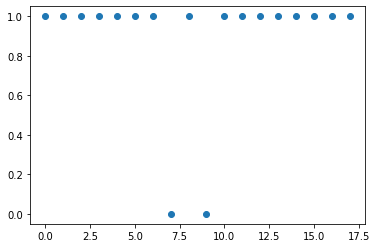

In [24]:
plt.scatter(list(range(len(results_of_eval[0]))), results_of_eval[-1])